# Ear Tracking detailed tutorial

In [1]:
%matplotlib notebook

import os
import cv2
import math as m
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

import openalea.eartrack
import openalea.eartrack.eartrack as et_lib
import openalea.eartrack.binarisation as et_bin
import openalea.eartrack.binarisation_folder as bin_f
import openalea.eartrack.notebook_module as nb_et
from openalea.deploy.shared_data import shared_data


def img_show(imgs, titles):
    fig, axes = plt.subplots(nrows=int((len(imgs)-1)/3) + 1, ncols=min(3, len(imgs)))
    axlist = fig.get_axes()
    for i in range(len(imgs)):
        axlist[i].axis('off')
        axlist[i].set_title(titles[i])
        axlist[i].imshow(imgs[i])
        

NOT using graph editor observer No module named grapheditor


## Get example images and parameters needed for segmentation and ear tracking

In [2]:
# Read images' information and create output folders
share_data_directory = shared_data(openalea.eartrack)
param_folder = os.path.join(share_data_directory, "parameters")
images_folder = os.path.join(share_data_directory, "images")

img_desc, parameters = bin_f.init(param_folder, images_folder, "", log=False)

## Selection of one plant and one imaging task

In [3]:
plant = img_desc.keys()[0]
task = img_desc[plant].keys()[0]

cabin = img_desc[plant][task]['cabin']

## Read images and display

<IPython.core.display.Javascript object>


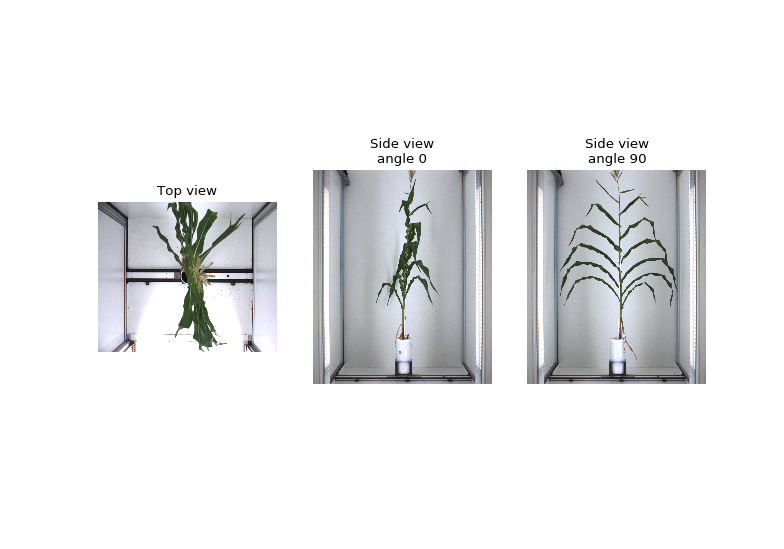

In [4]:
images = bin_f.read_images(img_desc, plant, task)

img_show([images["top"][0][:,:,::-1], images["side"][0][:,:,::-1], images["side"][90][:,:,::-1]], 
         ["Top view", "Side view\nangle 0", "Side view\nangle 90"])


## Compute binaries and display

<IPython.core.display.Javascript object>


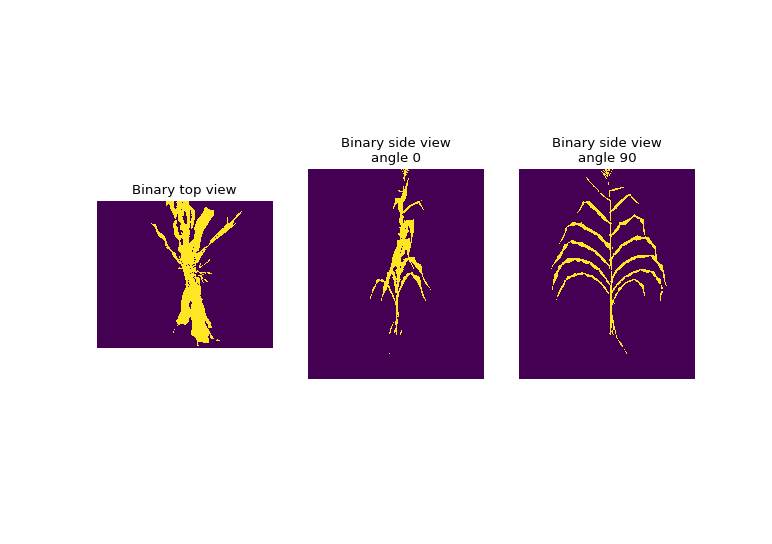

In [5]:
binaries, mask_top_center = bin_f.binaries_calculation(images, cabin, parameters)

img_show([binaries["top"][0], binaries["side"][0], binaries["side"][90]], 
         ["Binary top view", "Binary side view\nangle 0", "Binary side view\nangle 90"])

## Selection of best side view images based on top view image

### Compute robust major axis regression on top view image

<IPython.core.display.Javascript object>


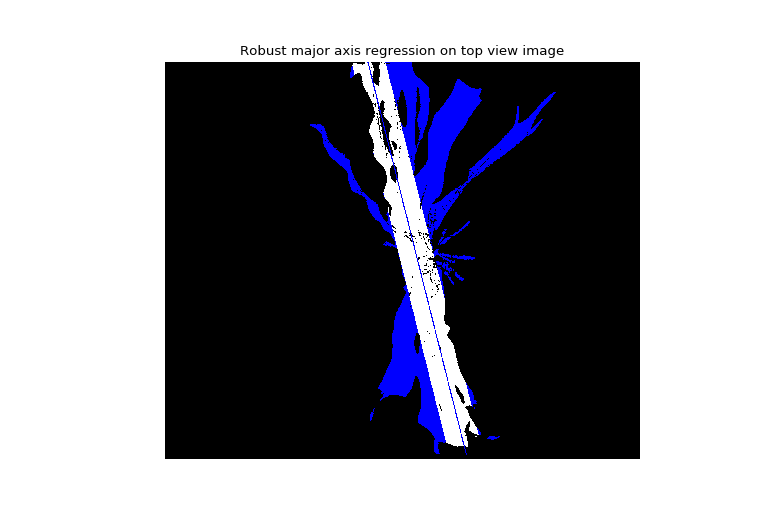

In [6]:
binary_img = binaries["top"][0].copy()

robust_img, reg_sum, perp_alphas, useless_pixels = nb_et.main_top_robust_regression(binary_img)

img_show([robust_img], ["Robust major axis regression on top view image"])

### Compute major axis regression on useless pixels to detect hampering leaves

<IPython.core.display.Javascript object>


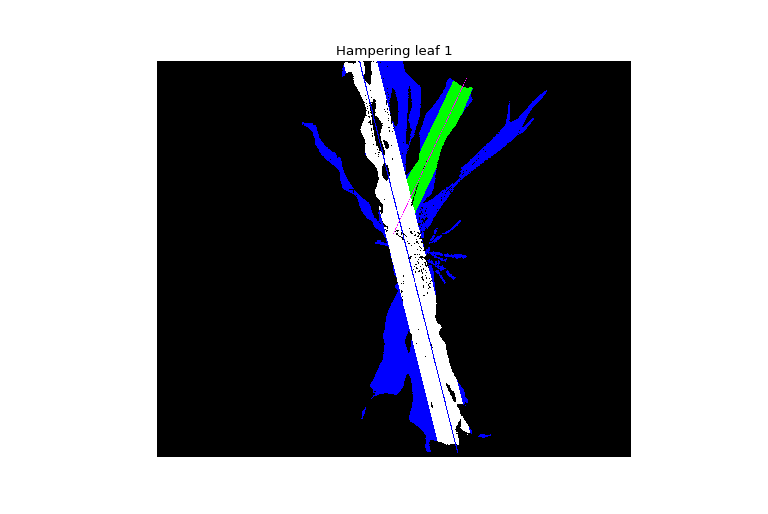

<IPython.core.display.Javascript object>


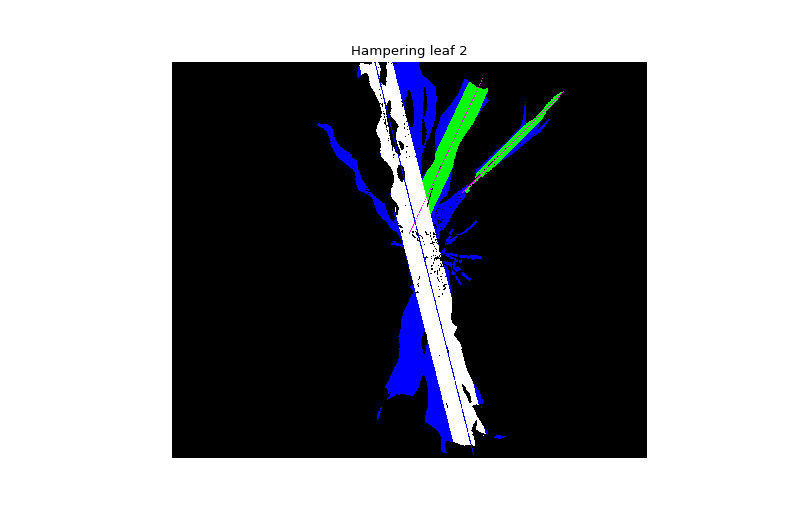

In [7]:
exclusions, plot_img = nb_et.hamper_top_robust_regression(binary_img, mask_top_center, useless_pixels, 
                                                          robust_img, reg_sum[0], reg_sum[1], reg_sum[2])

for title in sorted(plot_img.keys()):
    img_show([plot_img[title]], [title])

### Keep side views containing most information for ear detection

In [8]:
existing_angles = sorted(binaries["side"].keys())
angles_to_keep = nb_et.select_angles_to_keep(existing_angles, perp_alphas)
print("\n\nFirst step kept angles : " + ", ".join(map(str, angles_to_keep)))



First step kept angles : 90, 120, 270, 300


### Exclude side views for ear detection from hampering leaves detection

In [9]:
excluded_angles = nb_et.exclude_angles(angles_to_keep, exclusions)
print("\n\nSecond step excluded angles : " + ", ".join(map(str, excluded_angles)))
print("Finals kept angles : " + ", ".join(map(str, angles_to_keep)))



Second step excluded angles : 120
Finals kept angles : 90, 270, 300


## Find ear position in best side view images

### Detection on first selected side view image

In [10]:
kept_positions = np.empty([0, 3], 'int')
useful_kept_images = np.empty([0], 'int')
angle = angles_to_keep[0]

positions, imagesUtiles, side_log, img_debug = et_lib.side_analysis(binaries["side"][angle],
                                                                    images["side"][angle],
                                                                    angle,
                                                                    parameters[cabin]["side"]["pot_height"],
                                                                    parameters[cabin]["side"]["pot_width"])

kept_positions = np.append(kept_positions, positions, axis=0)
useful_kept_images = np.append(useful_kept_images, imagesUtiles, axis=0)

print(side_log[:side_log.find("Stem width : ")])


-----------------------------
Loading side_90.png
Stem width bellow the ear = 14
Stem with up to the ear = 7
Probable ear position : 876
Solutions : 
	solution : 876, weight : 2
	solution : 777, weight : 0
	solution : 632, weight : 0
	solution : 502, weight : 0
	solution : 373, weight : 0
Peaks (leaves) : 
	peak : 1138, begin : 1239, end : 1111, relative length : 6.77966101695
	peak : 1057, begin : 1082, end : 1040, relative length : 2.22457627119
	peak : 876, begin : 948, end : 873, relative length : 4.02542372881
	peak : 777, begin : 799, end : 761, relative length : 2.01271186441
	peak : 632, begin : 654, end : 627, relative length : 1.43008474576
	peak : 502, begin : 520, end : 493, relative length : 1.43008474576
	peak : 373, begin : 380, end : 369, relative length : 0.582627118644
	peak : 130, begin : 130, end : 129, relative length : 0.0529661016949
	peak : 38, begin : 82, end : 38, relative length : 2.33050847458
Troughs (stem part) : 
	begin : 870, end : 807, relative length 

<IPython.core.display.Javascript object>


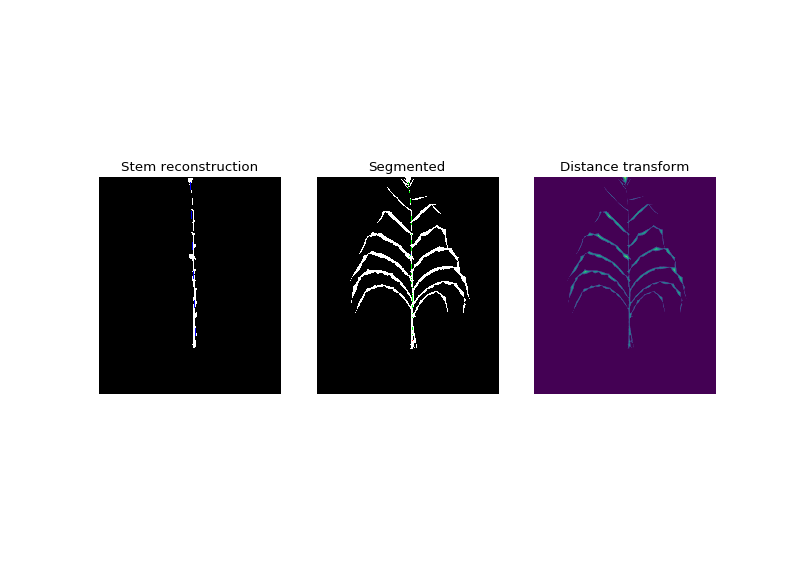

<IPython.core.display.Javascript object>


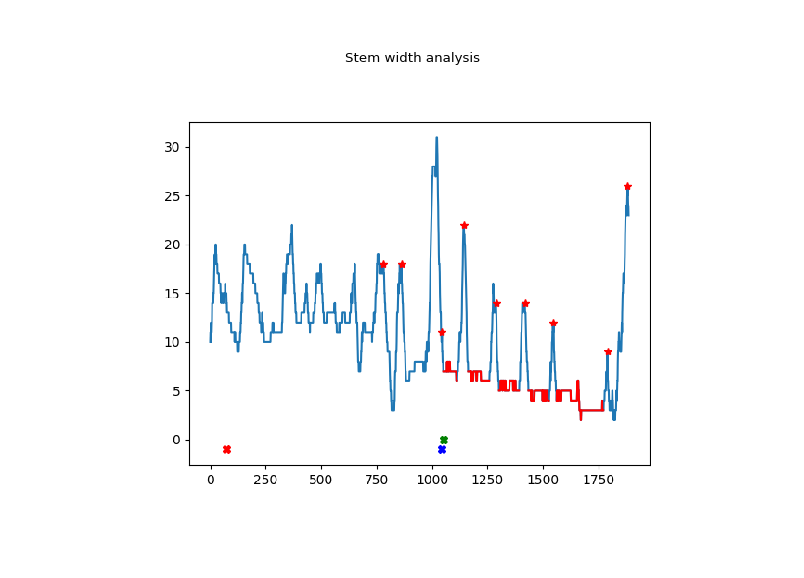

<IPython.core.display.Javascript object>


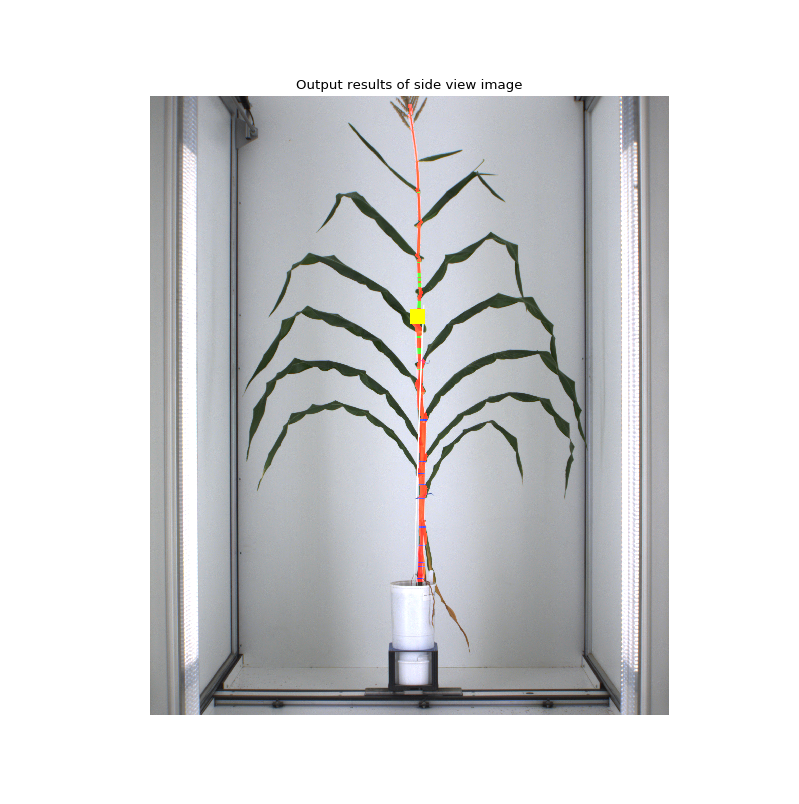

In [11]:
# show images
image_name = "side_" + str(angle) + ".png"
name, ext = os.path.splitext(image_name)
img_show([img_debug[name + "_cleaned_stem" + ext], 
          img_debug[name + "_binary" + ext], 
          img_debug[name + "_distance_transform" + ext]],
         ["Stem reconstruction", "Segmented", "Distance transform"])

img_show([img_debug[name + "_width_curve" + ext][:,:,::-1]], ["Stem width analysis"])
img_show([img_debug[name + "_result" + ext][:,:,::-1]], ["Output results of side view image"])


### Detection on remaining selected side view image(s) and display

Detected position as yellow square : 


<IPython.core.display.Javascript object>


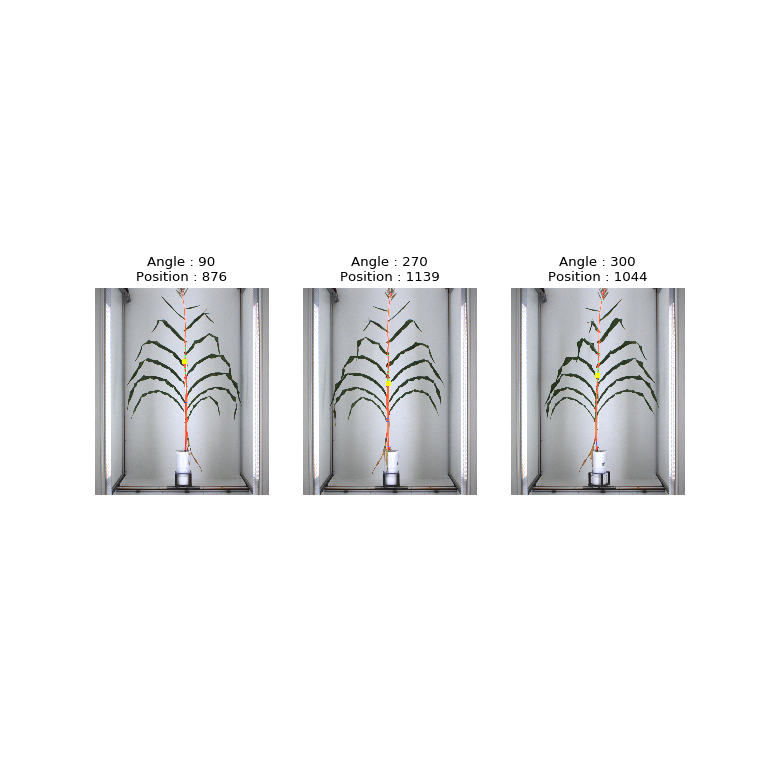

In [12]:
angle = angles_to_keep.pop(0)
plot_img = list()
plot_titles = list()
plot_img.append(img_debug[name + "_result" + ext][:,:,::-1])
plot_titles.append("Angle : " + str(angle) + "\nPosition : " + str(kept_positions[0][0]))
#img_show([output_results_img[:,:,::-1]], ["Angle : " + str(angle) + "\nPos : " + str(kept_positions[0][:2])])

for angle in angles_to_keep:
    positions, imagesUtiles, side_log, img_debug = et_lib.side_analysis(binaries["side"][angle],
                                                                       images["side"][angle],
                                                                       angle,
                                                                       parameters[cabin]["side"]["pot_height"],
                                                                       parameters[cabin]["side"]["pot_width"])
    kept_positions = np.append(kept_positions, positions, axis=0)
    useful_kept_images = np.append(useful_kept_images, imagesUtiles, axis=0)
    
    image_name = "side_" + str(angle) + ".png"
    name, ext = os.path.splitext(image_name)
    plot_img.append(img_debug[name + "_result" + ext][:,:,::-1])
    plot_titles.append("Angle : " + str(angle) + "\nPosition : " + str(positions[0][0]))
    #img_show([img_debug[name + "_result" + ext][:,:,::-1]], 
    #         ["Angle : " + str(angle) + "\nPos : " + str(positions[0][:2])])

print("Detected position as yellow square : ")
img_show(plot_img, plot_titles)

## Perform a vote between results and display final(s) ear position(s)

<IPython.core.display.Javascript object>


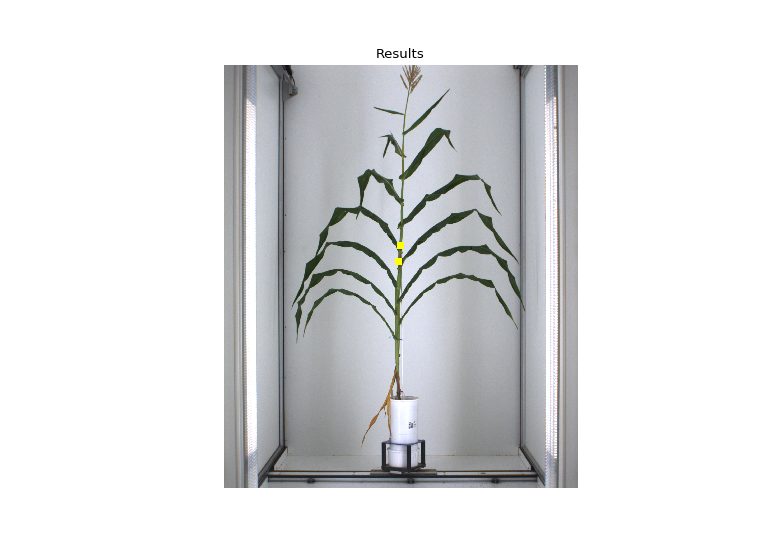

In [13]:
values = np.empty([0, 2], 'int')
im = np.empty([0], 'int')
for i in range(len(kept_positions)):
    for j in range(kept_positions[i, 2]):
        values = np.append(values, [kept_positions[i, 0:2]], axis=0)
        im = np.append(im, useful_kept_images[i])
mean_pos, finales_positions, final_kept_images = et_lib.robust_mean(values, im)
finales_positions = np.append(finales_positions, np.array([final_kept_images]).T, 1)


finale_img = images["side"][finales_positions[0, 2]].copy()
if not (mean_pos == [-1, -1]).all():
    pos = finales_positions[0, 0:2]
    finale_img[pos[0] - 20:pos[0] + 21, pos[1] - 20:pos[1] + 21, :] = [0, 255, 255]
elif finales_positions.shape[0] == 2:
    for pos in finales_positions:
        finale_img[pos[0] - 20:pos[0] + 21, pos[1] - 20:pos[1] + 21, :] = [0, 255, 255]
img_show([finale_img[:,:,::-1]], ["Results"])
